# <center> Analysis of Grade Inflation at the University of Maryland


Group Members: Jihyo Park, Calvin Pham

### <center> Introduction

Grades are a method of evaluation used to measure a student's academic learning. This allows instructors, employers, and colleges to determine how knowledgable a student is. Students worldwide share a common goal of increasing their grades to show that they have mastered the skills and knowledge from school. In recent times, high schools and colleges show signs of grade inflation worldwide. Grade inflation is a phenomonenon that is described as the awarding of higher grades for the same quality of work as time progresses. This phenomenon is critical to the world of education as it impacts students, universities, and employers. Grade inflation causes a variety of problems, for students and employers alike. Academic standards and effort drop, leading to students who are unprepared for the professional world. Some univesities that are known for grade inflation are Brown, Yale, Stanford, and Harvard. More info can be found here https://ripplematch.com/insights/the-top-20-universities-with-the-highest-average-gpas-84ef5edf/ 

There are multiple reasons why grade inflation may occur, ranging from institution's desire to have high graduation and retention rates, a professor's desire to have positive evaluations, along with other reasons. This is important to discuss because it may give students a false sense of ability, and reduce their motivation to learn. For employers, it may be harder to differentiate students who are qualified versus those who aren't based on inflated grades. Institutions who hold strict grading standards may suffer as they compete with institutions which show trends of inflated grades. More information on specific institutions can be found here https://en.wikipedia.org/wiki/Grade_inflation 

Today we will be focusing on grade data from the University of Maryland specifically. We will walk through the data science pipeline and reach conclusions on grade inflation for UMD CMSC courses. The data we are going to be analyzing comes from PlanetTerp, an open source project designed to help students at UMD make well informed decisions. This website pulls grade data from the University using PIA requests, which is made available for us to use here https://planetterp.com/api/ 

## Getting the Data & Preprocessing

As we have stated above, we are scraping our data from PlanetTerp. We are choosing to focus on computer science courses offered here at the University of Maryland. 

In [957]:
#imports
import requests # type: ignore
import pandas as pd # type: ignore
import numpy as np # type: ignore
import json
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf  # type: ignore
import seaborn as sns
import math
import pprint

Getting grade data for CMSC from PlanetTerp API. This will give us the list of courses we will further gather detailed yearly grade data from.

In [958]:
# cmsc_data = requests.get(f"https://planetterp.com/api/v1/courses?department=CMSC").json()
# with open('cmsc_data.json', 'w') as f:
#     json.dump(cmsc_data, f)

### Preprocessing the data
We choose to focus on undergraduate computer science classes offered at the University of Maryland, so we filter out the courses that are not 1XX, 2XX, 3XX, and 4XX. Next we drop unecessary columns that we are not going to use. 

We also have NaN values within our data. We chose to deal with this by dropping the rows entirely and not counting those courses in our analysis. We also didn't account for any courses that were less than 3 credits. (Which would filter out STICs and other low credit courses)

In [959]:
cmsc_df = pd.read_json('cmsc_data.json')
cmsc_df = cmsc_df.sort_values(by=['course_number'])

# only use 100, 200, 300, and 400 level courses
cmsc_df = cmsc_df[cmsc_df['course_number'].str.startswith(('1','2','3','4'))]

# drop unnecessary columns
cmsc_df.drop(columns=['professors', 'description', 'department', 'is_recent', 'geneds', 'title'], inplace=True)

cmsc_df.dropna(inplace=True)

cmsc_df.drop(cmsc_df[cmsc_df['credits'] < 3.0].index, inplace=True)

cmsc_df.head(10)

average_gpa course_number      name  credits
39     2.397251           106   CMSC106      4.0
16     2.527072           122   CMSC122      3.0
40     2.487990           131   CMSC131      4.0
41     2.602482           132   CMSC132      4.0
88     3.365746          132H  CMSC132H      4.0
4      2.471644           216   CMSC216      4.0
11     2.668913           250   CMSC250      4.0
48     3.448966          250H  CMSC250H      4.0
23     2.946301          289I  CMSC289I      3.0
71     3.388555           320   CMSC320      3.0

In [960]:
# Create a list of all the course names to use later
courses = cmsc_df['name'].values

Using our list of courses, we take each one and pull more further detailed grade data from PlanetTerp. 

In [961]:
# for x in courses:
#     grade_data = requests.get(f"https://api.planetterp.com/v1/grades?course={x}").json()
#     with open(f'./data/{x}.json', 'w') as f:
#         json.dump(grade_data, f)

In [962]:
#GPA weights according to the University of Maryland
gpa_map = {
    'A+':   4.0,
    'A':    4.0,
    'A-':   3.7, 
    'B+':   3.3,
    'B':    3.0,
    'B-':   2.7,
    'C+':   2.3,
    'C':    2.0, 
    'C-':   1.7, 
    'D+':   1.3, 
    'D':    1.0, 
    'D-':   0.7, 
    'F':    0.0,
}

grades = gpa_map.keys()
gpas = [gpa_map[grade] for grade in grades]

### Processing the data 

Using our list of undergraduate Computer Science courses with relevent grade data, we get grade data for each course ranging from years 2012-2023. We drop unused columns once again, but we then group all sections of a course together when counting up the letter grades. We also drop any course with 0 students as this data won't be applicable for our analysis. We also merge courses that have an honors section with its normal version. 

After cleaning up our data, we then start calculating the average gpa for each course during each semester from 2012-2023. We do this by converting the number of letter grades to gpa weights, then after taking the sum of the weights, we divide by the number of students in that course during that semester. 

In [963]:
# build a DataFrame with all course data
df = pd.DataFrame()

for x in courses:
    # we skip honors course in order to combine with non-honors equivalent course
    if x[-1] != 'H':
        grade_data = pd.read_json(f'./data/{x}.json')
        grade_data.drop(columns=['course', 'professor', 'section', "Other", "W"], inplace=True)
        grade_data = grade_data.groupby(['semester']).sum().reset_index()
        grade_data['students'] = grade_data[grades].sum(axis=1)
        grade_data.drop(grade_data[grade_data['students'] == 0].index, inplace=True)

        # we check if there is a honors equivalent course and merge with the non-honors if such course exists.
        if x + 'H' in courses:
            honors_data = pd.read_json(f'./data/{x}H.json')
            honors_data.drop(columns=['course', 'professor', 'section', "Other", "W"], inplace=True)
            honors_data = honors_data.groupby(['semester']).sum().reset_index()
            honors_data['students'] = honors_data[grades].sum(axis=1)
            grade_data = pd.concat([grade_data,honors_data]).groupby(['semester']).sum().reset_index()
        
        avg_gpa = []
        for index, row in grade_data.iterrows():
            avg_gpa.append(np.dot(row[grades], gpas) / row['students'])
        
        grade_data['avg_gpa'] = avg_gpa
        grade_data.drop(columns=grades, inplace=True)
        grade_data['course'] = x
        grade_data['level'] = int(x[4]) * 100
        
        df = pd.concat([df, grade_data])

df = df.reset_index()
df.drop(columns=['index'], inplace=True)
df['semester'] = df['semester'].apply(lambda x: x//100 if x % 10 == 1 else x//100 + 0.5)
df.head(20)

semester  students   avg_gpa   course  level
0     2012.5        44  2.650000  CMSC106    100
1     2013.5        49  2.342857  CMSC106    100
2     2014.5        36  2.961111  CMSC106    100
3     2015.5        37  2.445946  CMSC106    100
4     2016.5        42  2.421429  CMSC106    100
5     2017.5        34  2.588235  CMSC106    100
6     2018.5        34  2.805882  CMSC106    100
7     2019.5        38  3.176316  CMSC106    100
8     2020.5        30  2.736667  CMSC106    100
9     2021.5        47  3.227660  CMSC106    100
10    2022.0        37  2.872973  CMSC106    100
11    2022.5        17  2.376471  CMSC106    100
12    2023.0        20  2.790000  CMSC106    100
13    2023.5        39  3.194872  CMSC106    100
14    2012.0       175  2.602857  CMSC122    100
15    2012.5       203  2.740887  CMSC122    100
16    2013.0       203  3.035468  CMSC122    100
17    2013.5       214  3.222897  CMSC122    100
18    2014.0       208  2.822596  CMSC122    100
19    2014.5       213  2.710329  CMSC122    100

### Data Visualization

Now lets take our data and plot the average gpa of computer science courses from 2012 to 2023. 
We are going to group them by course level first, then individually after.

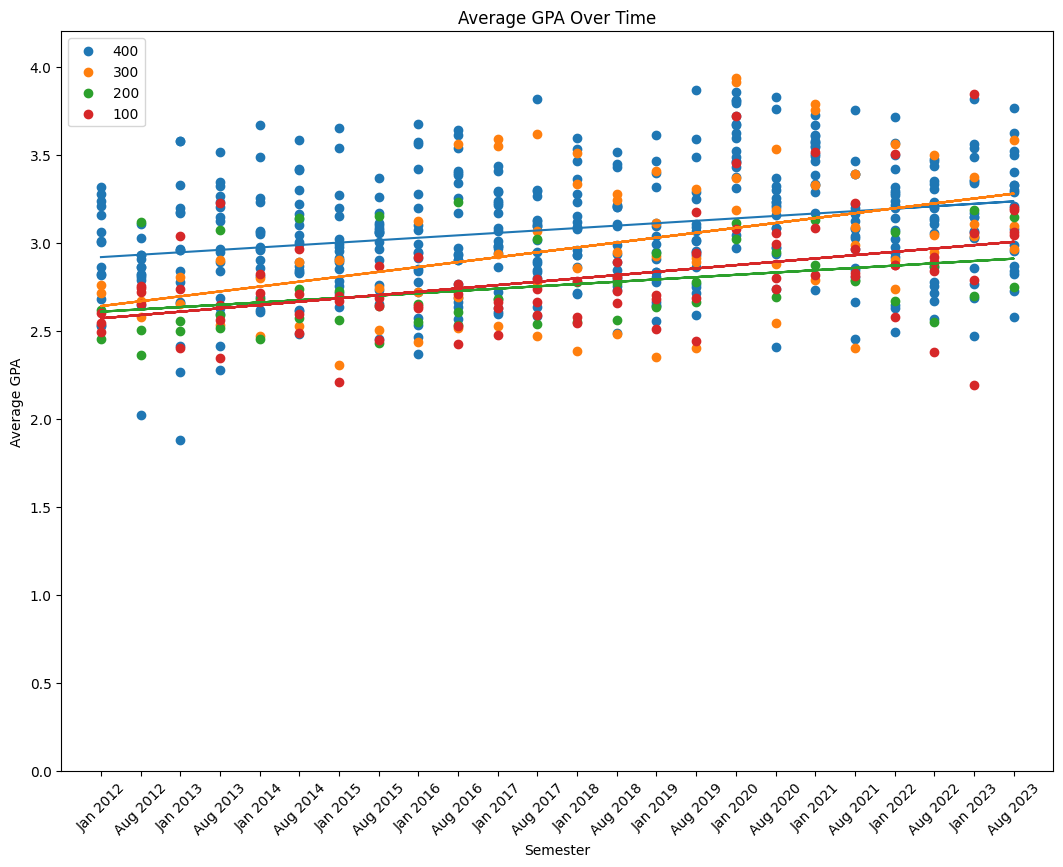

In [964]:
plt.figure(figsize=(12.8,9.6))

for level in [400,300,200,100]:
    course_data = df.loc[df["level"] == level]

    x = course_data["semester"]
    y = course_data["avg_gpa"]

    plt.scatter(x, y, label=level)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b)

plt.title("Average GPA Over Time")
plt.xlabel('Semester')
plt.ylabel('Average GPA')
plt.legend()
plt.tick_params(axis='x', labelrotation=45)
ticks = df["semester"].unique()
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(map(lambda x : "Jan " + str(math.floor(x)) if math.floor(x) == x else "Aug " + str(math.floor(x)), ticks))
plt.xlim(min(ticks) - 0.5, max(ticks) + 0.5)
plt.ylim(0, 4.2)

plt.show()

/var/folders/w8/2krv1jk52m5_qlhl8fs84ryw0000gn/T/ipykernel_15526/1974848220.py:13: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x, y, 1)


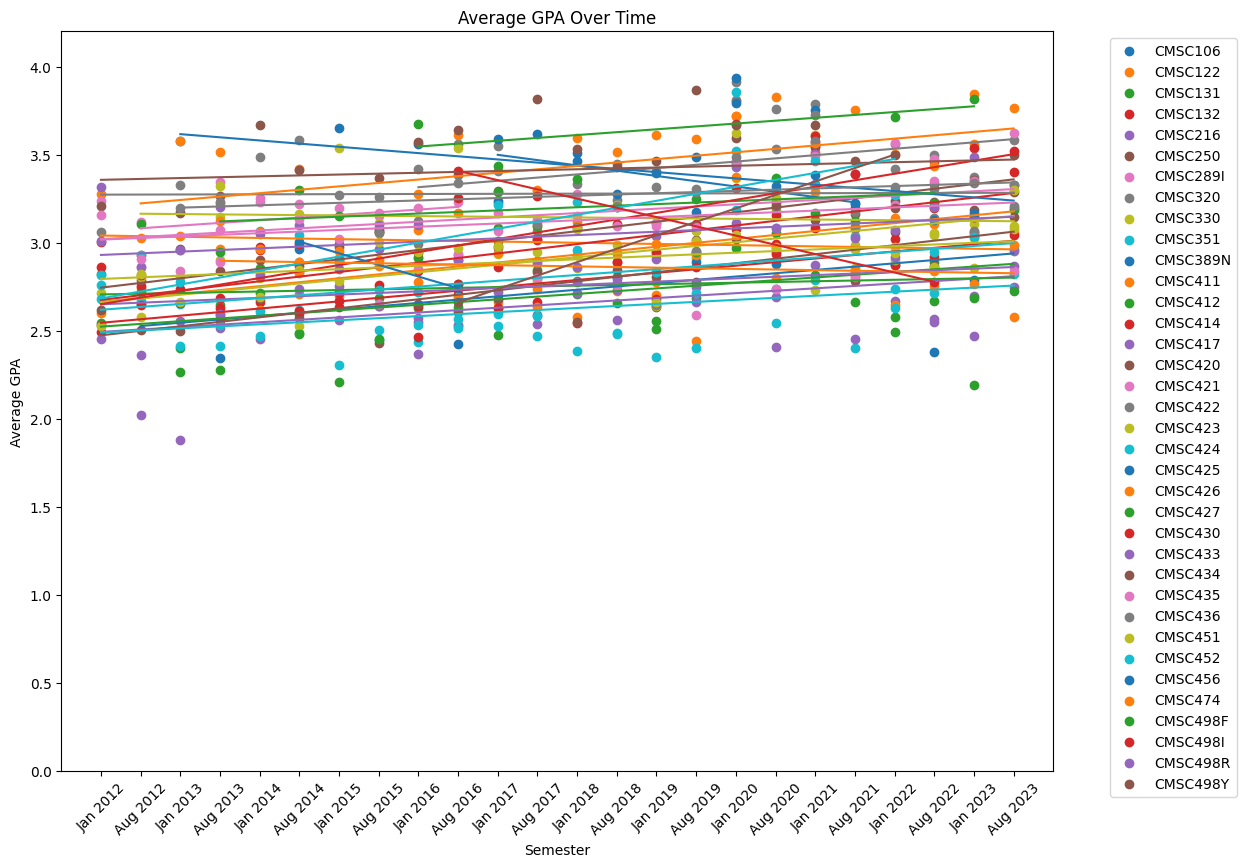

In [965]:
combined_courses = filter(lambda x : x[-1] != 'H', courses)

plt.figure(figsize=(12.8,9.6))

for course in combined_courses:
    course_data = df[df["course"] == course]

    x = course_data["semester"]
    y = course_data["avg_gpa"]

    plt.scatter(x, y, label=course)

    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b)

plt.title("Average GPA Over Time")
plt.xlabel('Semester')
plt.ylabel('Average GPA')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tick_params(axis='x', labelrotation=45)
ticks = df["semester"].unique()
plt.gca().set_xticks(ticks)
plt.gca().set_xticklabels(map(lambda x : "Jan " + str(math.floor(x)) if math.floor(x) == x else "Aug " + str(math.floor(x)), ticks))
plt.xlim(min(ticks) - 0.5, max(ticks) + 0.5)
plt.ylim(0, 4.2)

plt.show()

One thing to note while looking at these graphs is that the grade data for the 2020 school year is significantly higher than the year before and the year after. This may be due to the COVID-19 pandemic causing courses to adapt and change in a short period of time.

Analyzing our regression lines in the first graph, we can see that for any 1XX, 2XX, 3XX, 4XX level computer science course, the average gpa increased over time. There could be a number of reasons why this is the case, but we are interested in grade inflation. One trend to notice is that 1XX and 2XX level computer science courses have a lower average gpa when compared to 3XX and 4XX level courses. This could be due to courses that are designed to "weed out" students as they are typically more rigorous. These courses are also some of the first university level computer science courses a student will take, so it may impact their performance in these courses. 

In the second graph, things look a little cluttered, but the same trends show for most classes except a few. We will touch upon these specific courses later on, but the general trend for computer science courses is that the average gpa for a course has increased over time since 2012.

## Hypothesis Testing

Now we are going to utilize the statsmodels ordinary leasts squares function to test our hypothesis. This function allows us to view important statistics that which allow us to learn more about our data.

#### H0: There is no upwards trend in the average GPA of CMSC courses over time
#### H1: There is a linear trend in the average GPA of CMSC courses over time.
#### alpha = 0.05
### OLS

In [966]:

model = smf.ols(formula="avg_gpa ~ semester", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     68.96
Date:                Sat, 18 May 2024   Prob (F-statistic):           6.02e-16
Time:                        13:09:19   Log-Likelihood:                -210.44
No. Observations:                 640   AIC:                             424.9
Df Residuals:                     638   BIC:                             433.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -62.8175      7.926     -7.925      0.0

The p-value of 6.02e-16 is less than alpha of 0.05. There is statistically significant evidence to reject the null hypothesis. Since the coefficient is 0.0326, there is a positive correlation between average GPA and time, meaning that there is a 'grade inflation' in the UMD CMSC courses.

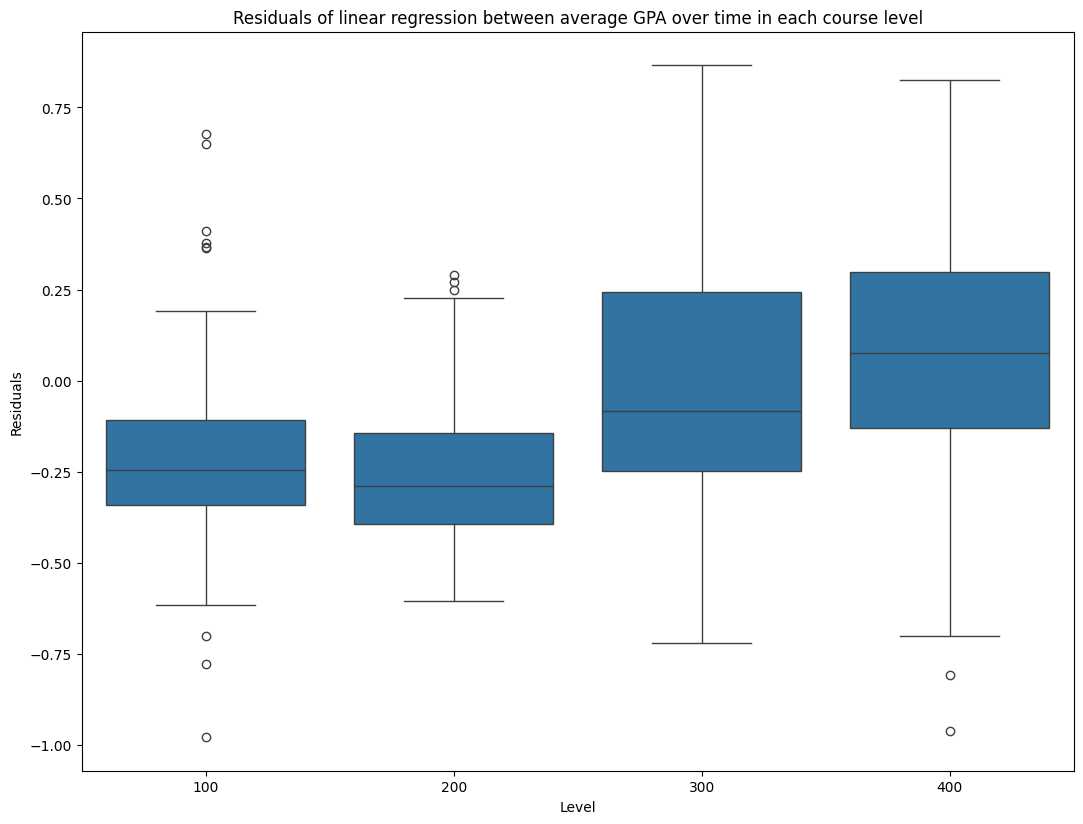

In [967]:
plt.figure(figsize=(12.8,9.6))

df["residuals"] = model.resid
sns.boxplot(data=df, x="level", y="residuals")
plt.xlabel("Level")
plt.ylabel("Residuals")
plt.title("Residuals of linear regression between average GPA over time in each course level")
plt.show()

Distribution of the model residuals vary slightly across each level thus the model residuals are likely not independent of the level. This suggests that regression analysis of average GPA across time should be performed seperately for each level. 

In [968]:

model = smf.ols(formula="avg_gpa ~ semester * C(level)", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     25.68
Date:                Sat, 18 May 2024   Prob (F-statistic):           5.68e-31
Time:                        13:09:19   Log-Likelihood:                -163.18
No. Observations:                 640   AIC:                             342.4
Df Residuals:                     632   BIC:                             378.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

We can also do regression analysis for every computer science course in our data.

In [969]:

model2 = smf.ols(formula="avg_gpa ~ semester * C(course)", data=df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_gpa   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     12.49
Date:                Sat, 18 May 2024   Prob (F-statistic):           2.97e-77
Time:                        13:09:19   Log-Likelihood:                 54.566
No. Observations:                 640   AIC:                             32.87
Df Residuals:                     569   BIC:                             349.6
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

We saw from our second scatterplot above that some courses have a decreasing trend in the average GPA. Lets filter out the courses with negative slopes in the OLS regresion result.

In [975]:
params_dict = model2.params[len(model2.params)//2:].to_dict()

new_dict = {key[21:-1] if key != "semester" else 'CMSC106': val+params_dict["semester"] for key,val in params_dict.items()}
new_dict["CMSC106"] /= 2
filtered = [item for item in new_dict.items() if item[1] < 0]
pprint.pp(filtered)

[('CMSC389N', -0.05996146936615966),
 ('CMSC411', -0.006816333899684848),
 ('CMSC423', -0.0038745658972591523),
 ('CMSC425', -0.03594492587521132),
 ('CMSC456', -0.132309197715415),
 ('CMSC474', -0.007089613348419108),
 ('CMSC498I', -0.10499999993808525)]


As we can see from our list of courses with a decreasing trend in average gpa, they are all 3XX or 4XX level courses. This is an interesting result as the average gpa for all 3XX and 4XX level courses seemed to be higher than the lower level courses. The only courses with a negative slope, or grade "deflation" are all upper level courses. This may be due to changes in curriculum, or unchanged curriculum with students who are less knowledgable. (an effect of grade inflation) There is a very small number of courses that show signs of grade deflation, so in general, there should not be a problem with inconsistent grading practices. 

### <center> Insight and Conclusion

After looking at all our data it is tempting to assume that grade inflation within the computer science department at the University of Maryland. In many articles that measure grade inflation, they typically use average gpa as measure of whether or not a school has grade inflation or not. However, solely looking at average gpa data alone will not give us the results we are looking for. It is important to consider whether or not the effort from students over each semester has been consistent. By the definition of grade inflation, effort must be consistent throughout the years if grades are increasing. In our study of UMD CS, it is important to factor in the effort of CS students here. 

From our data alone, we may conclude that computer science at the University of Maryland is grade inflated due to the positive relationship between average gpa and time. However, it is important to realize that effort among computer science students at UMD was not constant over theses years. This could be due to the university's rising status as a top computer science institution. It is fair to infer that as a university gets recognized for a specific field, people in that field will care more about the university. This logic can be applied with UMD CS, as its reputation within computer science draws in more students. This leads to an increase in competition, which pushes students to put more effort in. By this alone, we cannot be sure that UMD CS has grade inflation as student effort may have risen as well. We can see UMD's rise as a computer science school using this website https://csrankings.org/ 

You can find more information on grade inflation through these links:
https://www.gradeinflation.com/ 

https://xqsuperschool.org/education-policy/what-is-grade-inflation-and-why-does-it-matter/ 

https://en.wikipedia.org/wiki/Grade_inflation 


We soured our data using PlanetTerp's API so you can check out their website here
https://planetterp.com/

They also have a tool to view grade inflation by course or department which can be found here (Keep in mind that this is just a tool to view average gpa and doesn't measure effort)